<a href="https://colab.research.google.com/github/rezamohamadlo/Sunspot-Predictor/blob/main/Sunspot_Predictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
print(tf.__version__)

2.17.0


In [2]:
import numpy as np
import matplotlib.pyplot as plt
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [3]:
!wget --no-check-certificate \
    https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv

--2024-09-06 07:59:34--  https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 67921 (66K) [text/plain]
Saving to: ‘daily-min-temperatures.csv’

daily-min-temperatu 100%[===================>]  66.33K  --.-KB/s    in 0.01s   

2024-09-06 07:59:34 (4.55 MB/s) - ‘daily-min-temperatures.csv’ saved [67921/67921]



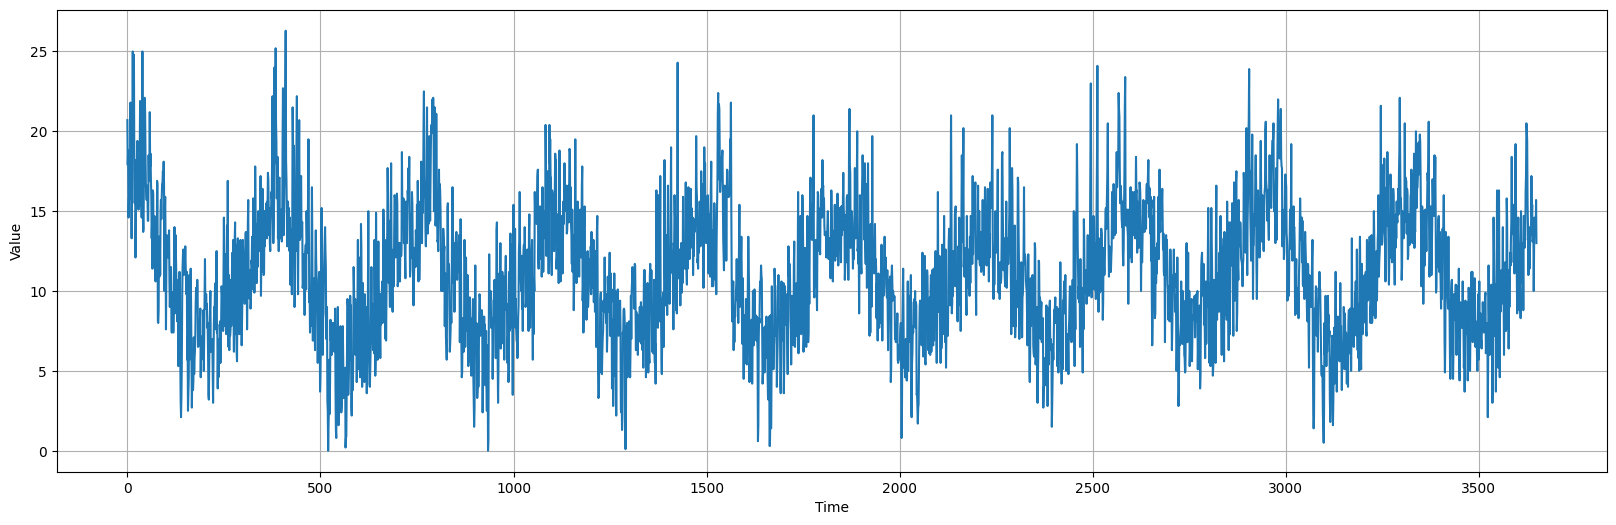

In [4]:
import csv
time_step = []
temps = []

with open('./daily-min-temperatures.csv') as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  next(reader)
  step=0
  for row in reader:
    temps.append(float(row[1]))
    time_step.append(step)
    step = step + 1

series = np.array(temps)
time = np.array(time_step)
plt.figure(figsize=(20, 6))
plot_series(time, series)


split_time = 2500
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000


In [5]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [6]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [7]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 1), dtype=tf.float64, name=None), TensorSpec(shape=(None, None, 1), dtype=tf.float64, name=None))>
(2500,)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 37ms/step - loss: 55.5065 - mae: 56.0065 - learning_rate: 1.0000e-08
Epoch 2/100


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 54.4677 - mae: 54.9677 - learning_rate: 1.1220e-08
Epoch 3/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 53.2957 - mae: 53.7957 - learning_rate: 1.2589e-08
Epoch 4/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 51.6213 - mae: 52.1213 - learning_rate: 1.4125e-08
Epoch 5/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 49.5449 - mae: 50.0448 - learning_rate: 1.5849e-08
Epoch 6/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 47.3564 - mae: 47.8564 - learning_rate: 1.7783e-08
Epoch 7/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 44.9210 - mae: 45.4210 - learning_rate: 1.9953e-08
Epoch 8/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 42.4134 - mae: 42.9133 - learning_rate: 2.2387e-08
Epoch 9/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 39.2729 - mae: 39.7728 - learning_rate: 2.5119e-08
Epoch 10/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 35.8763 - mae: 36.3762 - learning_rate: 2.8184e-08
Epoch 11/100

(1e-08, 0.0001, 0.0, 60.0)

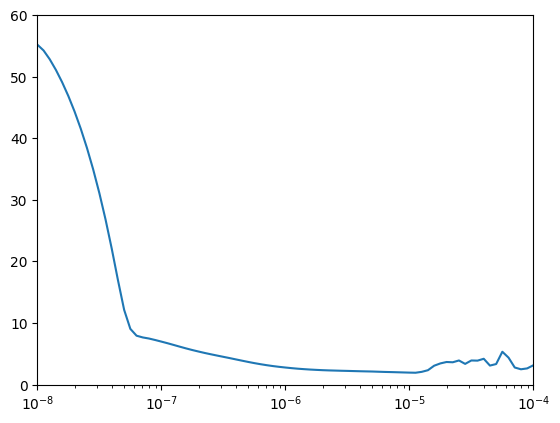

In [8]:
plt.semilogx(history.history["learning_rate"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 60])

In [9]:
print(history.history.keys())

dict_keys(['loss', 'mae', 'learning_rate'])


In [10]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])


optimizer = tf.keras.optimizers.SGD(learning_rate=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=150)

Epoch 1/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 9.1618 - mae: 9.6504
Epoch 2/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 2.4343 - mae: 2.8966
Epoch 3/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 2.0811 - mae: 2.5380
Epoch 4/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 1.9691 - mae: 2.4243
Epoch 5/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 1.9297 - mae: 2.3832
Epoch 6/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 1.8501 - mae: 2.3043
Epoch 7/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 1.8190 - mae: 2.2714
Epoch 8/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 1.7882 - mae: 2.2402
Epoch 9/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 1.7685 - mae: 2.2202
Epoch 10/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 1.7898 - mae: 2.2417
Epoch 11/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 1.7291 - mae: 2.1803
Epoch 12/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 1.7129 - mae: 2.1631
Epoch 13/150
25/25 ━━━━━━

In [11]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step


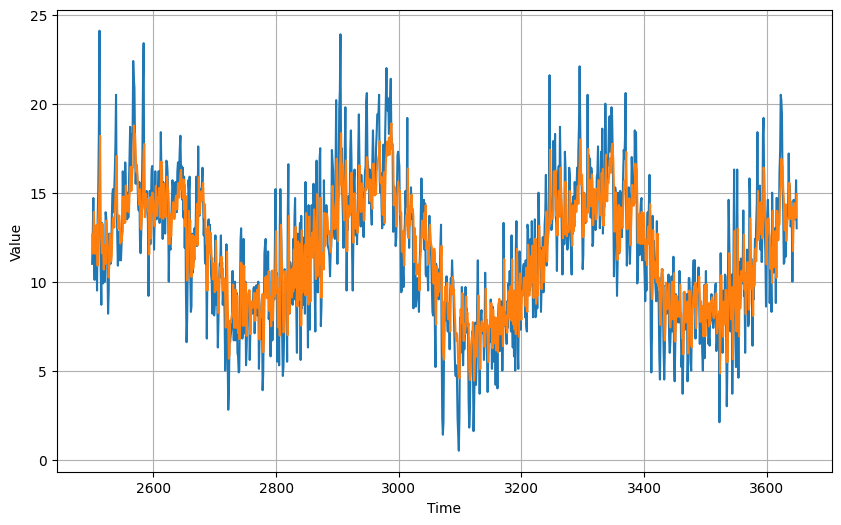

In [12]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [21]:
# Using Keras Mean Absolute Error
mae = tf.keras.losses.MeanAbsoluteError()
loss_value = mae(x_valid, rnn_forecast).numpy()
print(f'Mean Absolute Error (Keras API): {loss_value}')  # Output: Mean Absolute Error value

Mean Absolute Error (Keras API): 1.7928184270858765


In [22]:
print(rnn_forecast)

[12.630304 11.576035 12.650079 ... 13.558915 13.618287 14.922831]
